## Plotting composites ##

Plotting composites for two types of very bad winter days across three datasets: ERA5, DePreSys (10 members, Nov. init, first DJF), and CANARI (40 members, DJF).

1. Worst wind cold temp events - for each winter, this is where I've selected the day with the lowest wind speed and taken the corresponding temperature on that 'worst wind' day. I have then plotted these as a scatter and identified the very bad days, which are in both the 0th-50th percentile of the wind speeds for worst wind days and 0th-50th percentile of temperature for the worst temp days. These very bad days are what I am plotting as composites here.

2. Worst temp low wind events, same as above, but for the lowest temperature and then taking the corresponding wind speed.

In [1]:
# Imports
import os
import sys
import glob
import time
import re

# Third-party libraries
import numpy as np
import pandas as pd
import xarray as xr
import iris
import iris.coords
import cftime
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
import cartopy.crs as ccrs

# Specific third-party imports
from matplotlib import colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm
from scipy.stats import pearsonr
from iris.util import equalise_attributes

# Import types
from typing import Any, Callable, Union, List, Tuple

# Local imports
from plotting_functions import format_func, format_func_one_decimal

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# # Set up the file to the
# worst_temp_path = (
#     "/home/users/benhutch/unseen_multi_year/dfs/obs_worst_temp_low_wind_djf.csv"
# )
# worst_wind_path = (
#     "/home/users/benhutch/unseen_multi_year/dfs/obs_worst_wind_cold_temp_djf.csv"
# )

# # load these datarames
# worst_temp = pd.read_csv(worst_temp_path)
# worst_wind = pd.read_csv(worst_wind_path)

In [3]:
# # extract the worst temp dates
# worst_temp_dates = worst_temp["time_worst_tas_date"].values
# worst_temp_dates = pd.to_datetime(worst_temp_dates)

# # extract the worst wind dates
# worst_wind_dates = worst_wind["time_worst_wind_date"].values
# worst_wind_dates = pd.to_datetime(worst_wind_dates)

# # print these
# print(worst_temp_dates)
# print(worst_wind_dates)

In [4]:
# # Set up the path to the data
# data_path = (
#     "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_msl_daily_1960_2020_daymean.nc"
# )

# # Load the data
# psl_cube = iris.load_cube(data_path, "msl")

In [5]:
# define a function to plot the daily anoms or composites for a list of dates
# given the cube and the dates
def plot_daily_field(
    cube,
    dates: list,
    title: str,
    anoms: bool = False,  # By default, plot the absolute field
    composite: bool = False,  # By default, plot all of the dates as subplots
    months: list = [12, 1, 2],
    climatology_years: list = [1990, 2020],
) -> None:
    """
    Plots the daily field for a list of dates

    Args:
    ----

        cube: iris.cube.Cube
            The cube of the field
        dates: list
            A list of dates to plot
        title: str
            The title of the plot
        anoms: bool
            Whether to plot the anomalies or the absolute field
        composite: bool
            Whether to plot all of the dates as subplots
        months: list
            The months to extract
        climatology_years: list
            The years to use for the climatology

    Returns:
    -------

        None

    """

    # Convert the dates to cf time.datetime objects
    dates_this = [cftime.datetime(d.year, d.month, d.day) for d in dates]

    # Extract the dates from the cube
    cube_dates = cube.coord("time").points

    # Extract the time units and calendar from the time coordinate
    cube_time_units = cube.coord("time").units
    cube_calendar = cube.coord("time").units.calendar

    # Extract the date values from theb cube
    cube_datetime_values = cftime.num2date(
        cube_dates, units=cube_time_units.origin, calendar=cube_calendar
    )

    # Convert to cf time.datetime objects
    cube_datetime_values = [
        cftime.datetime(d.year, d.month, d.day) for d in cube_datetime_values
    ]

    # Print the dates this
    print(f"Dates to extract: {dates_this}")
    print(f"type of dates: {type(dates_this[0])}")

    # Print the cube dates
    print(f"Cube dates: {cube_datetime_values}")
    print(f"type of cube dates: {type(cube_datetime_values[0])}")

    # Set up an empty cube list
    cube_list = iris.cube.CubeList([])

    # Loop through the dates
    for date in dates_this:
        # Find the index of the date in the datetime values
        index = np.where(np.array(cube_datetime_values) == date)[0][0]

        # Extract the cube at the index
        cube_this = cube[index]

        # Append this cube to the list
        cube_list.append(cube_this)

    # Merge the cubes
    cube_merged = cube_list.merge_cube()

    # if anoms is true, calculate the climatology
    if anoms:
        # Extract the DJF data
        cube_djf = cube.extract(
            iris.Constraint(time=lambda cell: cell.point.month in months)
        )

        # Extract the 1990-2020 data
        cube_djf_1990_2020 = cube_djf.extract(
            iris.Constraint(
                time=lambda cell: climatology_years[0]
                <= cell.point.year
                <= climatology_years[1]
            )
        )

        # Take the mean over the time dimension
        cube_djf_1990_2020_mean = cube_djf_1990_2020.collapsed(
            "time", iris.analysis.MEAN
        )

        # Calculate the anomalies
        cube_anoms = cube_merged - cube_djf_1990_2020_mean

        # Set the cube merged to the cube anoms
        cube_merged = cube_anoms

        # Set up the clevs
        clevs = np.array(np.arange(-41, 41 + 1, 2))

        # remove the zero
        if 0 in clevs:
            clevs = np.delete(clevs, np.where(clevs == 0))

        ticks = clevs

        # ensure that these are floats
        clevs = clevs.astype(float)
        ticks = ticks.astype(float)

    else:
        # Set the cube merged to the cube
        cube_merged = cube_merged

        # Set up the clevs and ticks for absolution values
        clevs = np.array(np.arange(988, 1032 + 1, 4))
        ticks = clevs

        # ensure that these are floats
        clevs = clevs.astype(float)
        ticks = ticks.astype(float)

    # Set up the custom colormap
    # custom colormap
    cs = [
        "#4D65AD",
        "#3E97B7",
        "#6BC4A6",
        "#A4DBA4",
        "#D8F09C",
        "#FFFEBE",
        "#FFD27F",
        "#FCA85F",
        "#F57244",
        "#DD484C",
        "#B51948",
    ]
    cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

    # Set up the lons and lats
    lons = cube.coord("longitude").points
    lats = cube.coord("latitude").points

    # extract the field
    field_3d = cube_merged.data

    # if composite is true, plot a single plot
    if composite:
        print(f"Average over {len(dates_this)} dates")

        # Set up the figure
        fig, ax = plt.subplots(
            figsize=(12, 5), subplot_kw={"projection": ccrs.PlateCarree()}
        )

        # Set up the str for the date
        # remove the HH:MM:SS
        date_this_str = dates_this[0].strftime("%Y-%m-%d")

        # Set up the title
        # ax.set_title(f"{date_this_str}", fontsize=10, fontweight="bold")

        # Set up the field this
        field_this = np.mean(field_3d, axis=0)

        # Plot the data
        mymap = ax.contourf(
            lons,
            lats,
            field_this / 100,
            clevs,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            extend="both",
        )

        contours = ax.contour(
            lons,
            lats,
            field_this / 100,
            clevs,
            colors="black",
            transform=ccrs.PlateCarree(),
            linewidth=0.2,
            alpha=0.5,
        )

        ax.clabel(contours, clevs, fmt="%.1f", fontsize=8, inline=True, inline_spacing=0.0)

        ax.coastlines()

        # restrict the region to include all lons, but only lats between 30 and 80
        ax.set_extent([lons.min(), lons.max(), 30, 80])

        # format the gridlines and labels
        # format the gridlines and labels
        gl = ax.gridlines(
            draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
        )
        gl.xlabels_top = False
        gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {"size": 7, "color": "black"}
        gl.ylabels_right = False
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {"size": 7, "color": "black"}
        gl.ylabels_left = False
        gl.ylabels_right = False

        # turn off the top labels
        gl.top_labels = False
        gl.bottom_labels = False

        # Set a textbox in the top left with the date
        # set up the colorbar
        cbar = plt.colorbar(
            mymap,
            ax=ax,
            orientation="horizontal",
            shrink=0.8,
            pad=0.1,
            format=FuncFormatter(format_func_one_decimal),
        )

        if anoms:
            # Add colorbar label
            cbar.set_label(
                f"mean sea level pressure 1990-2020 DJF anomaly (hPa)",
                rotation=0,
                fontsize=10,
            )
        else:
            # Add colorbar label
            cbar.set_label(
                f"mean sea level pressure (hPa)",
                rotation=0,
                fontsize=10,
            )

        # Add contour lines to the colorbar
        cbar.add_lines(contours)

        # Set up the super title
        plt.suptitle(title, fontsize=12, fontweight="bold")
    else:
        print(f"Plotting {len(dates_this)} dates")

        # Set up the nrows, assuming ncols is 2
        nrows = int(np.ceil(len(dates_this) / 2))

        # Set up the figure
        fig, axs = plt.subplots(
            nrows=nrows,
            ncols=2,
            figsize=(12, 5 * nrows),
            subplot_kw={"projection": ccrs.PlateCarree()},
        )

        # Flatten the axs
        axs = axs.flatten()

        # loop over the zipped axs and dates
        for i, (ax, date) in enumerate(zip(axs, dates_this)):
            # # Set up the projection
            # ax = plt.subplot(1, 2, i + 1, projection=ccrs.PlateCarree())

            # set up the str for the date
            # remove the HH:MM:SS
            date_this_str = date.strftime("%Y-%m-%d")

            # # Set up the title
            # ax.set_title(f"{date}", fontsize=10, fontweight="bold") 

            # set up the field this
            field_this = field_3d[i]

            # Plot the data
            mymap = ax.contourf(
                lons,
                lats,
                field_this / 100,
                clevs,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                extend="both",
            )

            contours = ax.contour(
                lons,
                lats,
                field_this / 100,
                clevs,
                colors="black",
                transform=ccrs.PlateCarree(),
                linewidth=0.2,
                alpha=0.5,
            )

            ax.clabel(contours, clevs, fmt="%.1f", fontsize=8, inline=True, inline_spacing=0.0)

            ax.coastlines()

            # restrict the region to include all lons, but only lats between 30 and 80
            ax.set_extent([lons.min(), lons.max(), 30, 80])

            # format the gridlines and labels
            gl = ax.gridlines(
                draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
            )
            gl.xlabels_top = False
            gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
            gl.xformatter = LONGITUDE_FORMATTER
            gl.xlabel_style = {"size": 7, "color": "black"}
            gl.ylabels_right = False
            gl.yformatter = LATITUDE_FORMATTER
            gl.ylabel_style = {"size": 7, "color": "black"}
            gl.ylabels_left = False
            gl.ylabels_right = False

            # turn off the top labels
            gl.top_labels = False
            gl.bottom_labels = False

            # Properly turn off the labels
            # if i is 0
            if i == 0:
                gl.right_labels = False
            elif i == len(dates_this) - 1:
                gl.left_labels = False

            # Set a textbox in the top left with the date
            ax.text(
                0.02,
                0.95,
                f"{date_this_str}",
                verticalalignment="top",
                horizontalalignment="left",
                transform=ax.transAxes,
                color="black",
                fontsize=10,
                bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
            )

        # Set a tight layout
        plt.tight_layout()

        # Set up the colorbar
        cbar = plt.colorbar(
            mymap,
            ax=axs,
            orientation="horizontal",
            shrink=0.8,
            pad=0.1,
            format=FuncFormatter(format_func_one_decimal),
        )
        
        if anoms:
            # Add colorbar label
            cbar.set_label(
                f"mean sea level pressure 1990-2020 DJF anomaly (hPa)",
                rotation=0,
                fontsize=10,
            )
        else:
            # Add colorbar label
            cbar.set_label(
                f"mean sea level pressure (hPa)",
                rotation=0,
                fontsize=10,
            )

        # Add contour lines to the colorbar
        cbar.add_lines(contours)

        # Set up the super title
        plt.suptitle(title, fontsize=12, fontweight="bold")

    return None

In [6]:
# # test the function
# plot_daily_field(
#     cube=psl_cube,
#     dates=worst_wind_dates,
#     title="Worst wind dates",
#     anoms=False,
#     composite=False,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )

In [7]:
# Extract the new df
path = "/home/users/benhutch/unseen_multi_year/dfs/ERA5_worst_djf_wind_temp_days_DJF_1960-2013.csv"

full_obs_df = pd.read_csv(path)

In [8]:
# # Subset to the lowest 20th percentile of wind ("data_wind")
# data_wind_20th = full_obs_df["data_wind"].quantile(0.2)

# # Subset to the lowest 20th percentile of temperature ("data_tas")
# full_obs_df_subset_20th_wind = full_obs_df[full_obs_df["data_wind"] <= data_wind_20th]


In [9]:
# # extract the dates from this
# worst_wind_20th_dates = full_obs_df_subset_20th_wind["time_worst_wind_date"].values

In [10]:
# # convert these to datetime objects
# worst_wind_20th_dates = pd.to_datetime(worst_wind_20th_dates)

In [11]:
# # plot these
# plot_daily_field(
#     cube=psl_cube,
#     dates=worst_wind_20th_dates,
#     title="Worst wind dates 20th percentile",
#     anoms=False,
#     composite=True,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )

In [12]:
# # set up the 20th percentile for temperature
# data_tas_20th = full_obs_df["data_tas"].quantile(0.2)

# # Subset to the lowest 20th percentile of temperature ("data_tas")
# full_obs_df_subset_20th_temp = full_obs_df[full_obs_df["data_tas"] <= data_tas_20th]

# # extract the dates from this
# worst_temp_20th_dates = full_obs_df_subset_20th_temp["time_worst_tas_date"].values

# # convert these to datetime objects
# worst_temp_20th_dates = pd.to_datetime(worst_temp_20th_dates)

In [13]:
# data_tas_20th_dt = full_obs_df["data_tas_dt"].quantile(0.2)

# # Subset to the lowest 20th percentile of temperature ("data_tas")
# full_obs_df_subset_20th_temp_dt = full_obs_df[full_obs_df["data_tas_dt"] <= data_tas_20th_dt]

# # extract the dates from this
# worst_temp_20th_dates_dt = full_obs_df_subset_20th_temp_dt["time_worst_tas_date"].values

# # assert that these are the same
# assert np.all(worst_temp_20th_dates == full_obs_df_subset_20th_temp["time_worst_tas_date"].values)

In [14]:
# # plot these
# plot_daily_field(
#     cube=psl_cube,
#     dates=worst_temp_20th_dates,
#     title="Worst temperature dates 20th percentile",
#     anoms=False,
#     composite=True,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )

In [15]:
# # extract all of the dates for time_worst wind
# worst_wind_dates = full_obs_df["time_worst_wind_date"].values

# # convert these to datetime objects
# worst_wind_dates = pd.to_datetime(worst_wind_dates)

# # extract all of the dates for time_worst tas
# worst_temp_dates = full_obs_df["time_worst_tas_date"].values

# # convert these to datetime objects
# worst_temp_dates = pd.to_datetime(worst_temp_dates)

In [16]:
# # plot these
# plot_daily_field(
#     cube=psl_cube,
#     dates=worst_temp_dates,
#     title="Worst temperature dates",
#     anoms=True,
#     composite=True,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )

In [17]:
# # same buyt for the wind
# plot_daily_field(
#     cube=psl_cube,
#     dates=worst_wind_dates,
#     title="Worst wind dates",
#     anoms=True,
#     composite=True,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )

## Same for DePreSys ##

now for the slightly harder bit

In [18]:
# Set up the path 
dps_path = "/home/users/benhutch/unseen_multi_year/dfs/DePreSys_worst_djf_wind_temp_days_DJF_1960-2013_first_winter_daily.csv"

# Load the data
dps_df = pd.read_csv(dps_path)

In [19]:
# dps_df.head()

In [20]:
# # find the lowest data_wind day
# # subset the df to this row
# dps_df_subset_lowest_wind = dps_df[dps_df["data_wind"] == dps_df["data_wind"].min()]

In [21]:
# # reset the index
# dps_df_subset_lowest_wind = dps_df_subset_lowest_wind.reset_index(drop=True)

In [22]:
# given a list of tuples, containing effective_dec_year, member, and lead
# find the correct .nc file to extract the data from
# and extract the data for that specific init year member lead
def plot_dps_composite(
    df: pd.DataFrame,
    title: str,
    lead: str = "time_worst_wind_lead",
    anoms: bool = False,
    composite: bool = False,
    months: list = [12, 1, 2],
    climatology_years: list = [1990, 2020],
) -> None:
    """
    Plots the daily field for a list of init year, member, and lead
    specified in the dataframe.
    
    Args:
    -----
            
        df: pd.DataFrame
            The dataframe containing the data
        title: str
            The title of the plot
        lead: str
            The lead to use for the plot
        anoms: bool
            Whether to plot the anomalies or the absolute field
        composite: bool
            Whether to plot all of the dates as subplots
        months: list
            The months to extract
        climatology_years: list
            The years to use for the climatology
            
    Returns:
    --------
    
        None
    
    """

    # Hard code the base path
    base_path = "/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/"

    # set up the dictionary to store the init year, member, and lead
    init_year_member_lead_dict = {
        "init_year": [],
        "member": [],
        "lead": []
    }

    for i, row in df.iterrows():
        # extract the init year, member, and lead
        init_year_member_lead_dict["init_year"].append(int(row["effective_dec_year"]))
        init_year_member_lead_dict["member"].append(int(row["member"]))
        init_year_member_lead_dict["lead"].append(int(row[lead]))

    # print the dictionary
    print(init_year_member_lead_dict)

    # Set up an empty cube list
    cube_list = []

    # set up the dates list
    dates = []

    # Loop over the dictionary
    for i, (init_year, member, lead) in tqdm(enumerate(
        zip(
            init_year_member_lead_dict["init_year"],
            init_year_member_lead_dict["member"],
            init_year_member_lead_dict["lead"],
        )
    )
    ):
        # Set up the second half of the path
        path_this = f"s{init_year}-r{member}i1p1f2/day/psl/gn/files/d*/"

        # if the lead is 60 or less, then the fname to extract is different
        if lead <= 60:
            # Set up the fname
            # psl_day_HadGEM3-GC31-MM_dcppA-hindcast_s2014-r1i1p1f2_gn_20141101-20141230.nc
            fname = f"psl_day_HadGEM3-GC31-MM_dcppA-hindcast_s{init_year}-r{member}i1p1f2_gn_{init_year}1101-{init_year}1230.nc"
        else:
            # Set up the fname
            # psl_day_HadGEM3-GC31-MM_dcppA-hindcast_s2014-r1i1p1f2_gn_20150101-20151230.nc
            fname = f"psl_day_HadGEM3-GC31-MM_dcppA-hindcast_s{init_year}-r{member}i1p1f2_gn_{init_year + 1}0101-{init_year + 1}1230.nc"

        # Set up the full path
        full_path_this = os.path.join(base_path, path_this, fname)

        # glob the full path
        full_path_this = glob.glob(full_path_this)

        # if the file exists, load the cube
        if os.path.exists(full_path_this[0]):
            # Load the cube
            cube = iris.load_cube(full_path_this, "psl")

            # extract the date
            if lead <= 60:
                # Extract the index lead - 1
                index = lead - 1
            else:
                # extract the date
                index = lead - 61

            # Extract the date
            date_this = cube.coord("time").points[index]
            date_this = cftime.num2date(date_this, cube.coord("time").units.origin, cube.coord("time").units.calendar)

            # if the date_this is not in the dates list, append it
            if date_this not in dates:
                dates.append(date_this)
            else:
                print(f"Date {date_this} already in the dates list")

            # # # print the date
            # print(f"extracting date: {date_this}")

            # apply this to the cube
            cube_subset = cube[index]

            # Add auxiliary coordinate 'i'
            # aux_coord = iris.coords.AuxCoord(i, long_name='i')
            # cube_subset.add_aux_coord(aux_coord)

            # Append the cube to the list
            cube_list.append(cube_subset)
        else:
            print(f"File {full_path_this} does not exist")

    # print the cube list
    print(cube_list)

    # Convert cube_list to a cube
    cube_list= iris.cube.CubeList(cube_list)

    # print cube_merged
    print(cube_list)

    # remove the bad attributes
    remove_attributes = equalise_attributes(cube_list)

    # merge the cube list
    cube_merged = cube_list.merge_cube()

    # concatenate the cube list
    # cube_merged = cube_list.concatenate_cube()

    # print the cube merged
    print(cube_merged)

    # if anoms is true, calculate the climatology
    if anoms:
        # TODO: Remove the DJF montlhly mean?
        raise NotImplementedError

        # Set the cube merged to the cube anoms
        cube_merged = cube_anoms

        # Set up the clevs
        clevs = np.array(np.arange(-41, 41 + 1, 2))

        # remove the zero
        if 0 in clevs:
            clevs = np.delete(clevs, np.where(clevs == 0))

        ticks = clevs

        # ensure that these are floats
        clevs = clevs.astype(float)
        ticks = ticks.astype(float)
    else:
        # Set the cube merged to the cube
        cube_merged = cube_merged

        # Set up the clevs and ticks for absolution values
        clevs = np.array(np.arange(988, 1032 + 1, 4))
        ticks = clevs

        # ensure that these are floats
        clevs = clevs.astype(float)
        ticks = ticks.astype(float)

    # Set up the custom colormap
    # custom colormap
    cs = [
        "#4D65AD",
        "#3E97B7",
        "#6BC4A6",
        "#A4DBA4",
        "#D8F09C",
        "#FFFEBE",
        "#FFD27F",
        "#FCA85F",
        "#F57244",
        "#DD484C",
        "#B51948",
    ]
    cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

    # convert cube to -180 to 180
    cube_merged = cube_merged.intersection(longitude=(-180, 180))

    # Set up the lons and lats
    lons = cube.coord("longitude").points
    lats = cube.coord("latitude").points

    # extract the field
    field_3d = cube_merged.data

    # if composite is true, plot a single plot
    if composite:
        print(f"Average over {len(df)} days")

        # Set up the figure
        fig, ax = plt.subplots(
            figsize=(12, 5), subplot_kw={"projection": ccrs.PlateCarree()}
        )

        # Set up the str for the date
        # remove the HH:MM:SS
        n_days = len(df)

        # Set up the title
        # ax.set_title(f"{date_this_str}", fontsize=10, fontweight="bold")

        # Set up the field this
        field_this = np.mean(field_3d, axis=0)

        # Plot the data
        mymap = ax.contourf(
            lons,
            lats,
            field_this / 100,
            clevs,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            extend="both",
        )

        contours = ax.contour(
            lons,
            lats,
            field_this / 100,
            clevs,
            colors="black",
            transform=ccrs.PlateCarree(),
            linewidth=0.2,
            alpha=0.5,
        )

        ax.clabel(contours, clevs, fmt="%.1f", fontsize=8, inline=True, inline_spacing=0.0)

        ax.coastlines()

        # restrict the region to include all lons, but only lats between 30 and 80
        ax.set_extent([-35, 35, 30, 80])

        # format the gridlines and labels
        # format the gridlines and labels
        gl = ax.gridlines(
            draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
        )
        gl.xlabels_top = False
        gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {"size": 7, "color": "black"}
        gl.ylabels_right = False
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {"size": 7, "color": "black"}
        gl.ylabels_left = False
        gl.ylabels_right = False

        # turn off the top labels
        gl.top_labels = False
        gl.bottom_labels = False

        # Set a textbox in the top left with the date
        # set up the colorbar
        cbar = plt.colorbar(
            mymap,
            ax=ax,
            orientation="horizontal",
            shrink=0.8,
            pad=0.1,
            format=FuncFormatter(format_func_one_decimal),
        )

        # include a textbox in the top left with the N
        ax.text(
            0.05,
            0.95,
            f"N = {n_days}",
            verticalalignment="top",
            horizontalalignment="left",
            transform=ax.transAxes,
            color="black",
            fontsize=10,
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
        )

        if anoms:
            # Add colorbar label
            cbar.set_label(
                f"mean sea level pressure 1990-2020 DJF anomaly (hPa)",
                rotation=0,
                fontsize=10,
            )
        else:
            # Add colorbar label
            cbar.set_label(
                f"mean sea level pressure (hPa)",
                rotation=0,
                fontsize=10,
            )

        # Add contour lines to the colorbar
        cbar.add_lines(contours)

        # Set up the super title
        plt.suptitle(title, fontsize=12, fontweight="bold")
    else:
        print(f"Plotting {len(df)} days")

        # Set up the nrows, assuming ncols is 2
        nrows = int(np.ceil(len(df) / 2))

        # Set up the figure
        fig, axs = plt.subplots(
            nrows=nrows,
            ncols=2,
            figsize=(12, 5 * nrows),
            subplot_kw={"projection": ccrs.PlateCarree()},
        )

        # Flatten the axs
        axs = axs.flatten()

        # loop over the zipped axs and dates
        for i, (ax, iyear) in enumerate(zip(axs, init_year_member_lead_dict["init_year"])):
            # # Set up the projection
            # ax = plt.subplot(1, 2, i + 1, projection=ccrs.PlateCarree())
            # extract the member and lead
            member_this = init_year_member_lead_dict["member"][i]
            lead_this = init_year_member_lead_dict["lead"][i]

            # set up the field this
            field_this = field_3d[i]

            # Plot the data
            mymap = ax.contourf(
                lons,
                lats,
                field_this / 100,
                clevs,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                extend="both",
            )

            contours = ax.contour(
                lons,
                lats,
                field_this / 100,
                clevs,
                colors="black",
                transform=ccrs.PlateCarree(),
                linewidth=0.2,
                alpha=0.5,
            )

            ax.clabel(contours, clevs, fmt="%.1f", fontsize=8, inline=True, inline_spacing=0.0)

            ax.coastlines()

            # restrict the region to include all lons, but only lats between 30 and 80
            ax.set_extent([-35, 35, 30, 80])

            # format the gridlines and labels
            gl = ax.gridlines(
                draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
            )
            gl.xlabels_top = False
            gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
            gl.xformatter = LONGITUDE_FORMATTER
            gl.xlabel_style = {"size": 7, "color": "black"}
            gl.ylabels_right = False
            gl.yformatter = LATITUDE_FORMATTER
            gl.ylabel_style = {"size": 7, "color": "black"}
            gl.ylabels_left = False
            gl.ylabels_right = False

            # turn off the top labels
            gl.top_labels = False
            gl.bottom_labels = False
            gl.right_labels = False
            gl.left_labels = False

            # # Properly turn off the labels
            # # if i is 0
            # if i == 0:
            #     gl.right_labels = False
            # elif i == len(df) - 1:
            #     gl.left_labels = False

            # Set a textbox in the top left with the date
            ax.text(
                0.05,
                0.95,
                f"Init. year = {iyear}\n Member = {member_this}\n Lead = {lead_this}",
                verticalalignment="top",
                horizontalalignment="left",
                transform=ax.transAxes,
                color="black",
                fontsize=10,
                bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
            )

        # Set up the colorbar
        cbar = plt.colorbar(
            mymap,
            ax=axs,
            orientation="horizontal",
            shrink=0.8,
            pad=0.1,
            format=FuncFormatter(format_func_one_decimal),
        )
        
        if anoms:
            # Add colorbar label
            cbar.set_label(
                f"mean sea level pressure 1990-2020 DJF anomaly (hPa)",
                rotation=0,
                fontsize=10,
            )
        else:
            # Add colorbar label
            cbar.set_label(
                f"mean sea level pressure (hPa)",
                rotation=0,
                fontsize=10,
            )

        # Add contour lines to the colorbar
        cbar.add_lines(contours)

        # Set up the super title
        plt.suptitle(title, fontsize=12, fontweight="bold")

        # # Set a tight layout
        # plt.tight_layout()

    return None

In [23]:
# # subset the cube to the 1th percentile of wind
# dps_df_subset_lowest_wind_10th = dps_df[dps_df["data_wind"] == dps_df["data_wind"].quantile(0.10)]

In [24]:
# data_wind_10th = dps_df["data_wind"].quantile(0.10)

# # subset the df to the 10th percentile of wind
# dps_df_subset_lowest_wind_10th = dps_df[dps_df["data_wind"] <= data_wind_10th]

In [25]:
# data_wind_1th = dps_df["data_wind"].quantile(0.01)

# # subset the df to the 1th percentile of wind
# dps_df_subset_lowest_wind_1th = dps_df[dps_df["data_wind"] <= data_wind_1th]

In [26]:
# # calculate the 20th centile for data wind
# dps_data_wind_20th = dps_df["data_wind"].quantile(0.2)

# # subset the df to the 20th percentile of wind
# dps_df_subset_lowest_wind_20th = dps_df[dps_df["data_wind"] <= dps_data_wind_20th]

In [27]:
# # print the rows where dps_df_subset_lowest_wind_20th has effective dec year 2004
# dps_df_subset_lowest_wind_20th[dps_df_subset_lowest_wind_20th["effective_dec_year"] == 2004]

In [28]:
# # remove row at index 446 as a bodge fix
# dps_df_subset_lowest_wind_20th = dps_df_subset_lowest_wind_20th.drop(446)

In [29]:
# # test the function
# plot_dps_composite(
#     df=dps_df_subset_lowest_wind_20th,
#     title="Lowest wind days (DePreSys 20th percentile, DJF)",
#     lead="time_worst_wind_lead",
#     anoms=False,
#     composite=True,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )

Some part of DePreSys processing doesn't appear to be working correctly. To check whether the method we are applying is valid, let's now check the Canari composites to see whether they look more realistic.

In [30]:
# Set up the path to the canari data
canari_path = "/home/users/benhutch/unseen_multi_year/dfs/Canari_worst_djf_wind_temp_days_DJF_1960-2013.csv"

# Load the data
canari_df = pd.read_csv(canari_path)

In [31]:
canari_df.head()

,effective_dec_year,member,time_worst_wind,time_worst_tas,data_wind,data_tas_worst_wind,data_tas,data_wind_worst_tas,data_tas_dt,data_tas_worst_wind_dt
0,1960,1,1961-01-30,1960-12-21,1.892235,2.861436,-1.445395,2.481561,2.242008,6.548839
1,1960,2,1961-02-19,1961-02-02,2.027462,6.023582,-3.529893,3.503737,0.157511,9.710985
2,1960,3,1960-12-03,1961-01-13,2.880504,-1.685843,-6.243748,5.547405,-2.556345,2.001560
3,1960,4,1960-12-29,1961-01-23,1.600568,-1.297926,-5.877452,2.892183,-2.190049,2.389477
4,1960,5,1960-12-26,1961-01-03,2.514957,2.212363,-4.750289,4.193209,-1.062886,5.899766


In [32]:
# # subset the cube to the 1th percentile of wind
canari_lowest_wind_1th = canari_df["data_wind"].quantile(0.01)

# # subset the df to the 1th percentile of wind
canari_df_subset_lowest_wind_1th = canari_df[canari_df["data_wind"] <= canari_lowest_wind_1th]

In [33]:
canari_df_subset_lowest_wind_1th.head()

,effective_dec_year,member,time_worst_wind,time_worst_tas,data_wind,data_tas_worst_wind,data_tas,data_wind_worst_tas,data_tas_dt,data_tas_worst_wind_dt
258,1966,19,1966-12-11,1966-12-29,1.553527,1.892333,-10.344365,1.971412,-6.835544,5.401154
323,1968,4,1969-01-12,1969-02-08,1.458429,1.120310,-2.952701,2.837334,0.496593,4.569604
324,1968,5,1968-12-05,1968-12-13,1.523202,-4.031633,-6.634977,3.219194,-3.185684,-0.582339
492,1972,13,1972-12-20,1973-02-17,1.544104,1.161670,-1.223123,4.799125,2.107116,4.491909
615,1975,16,1976-02-05,1975-12-02,1.507712,0.352577,-3.687092,2.213034,-0.446144,3.593525


In [34]:
# set up the 0.1th percentile for wind
canari_lowest_wind_0_1th = canari_df["data_wind"].quantile(0.001)

# subset the df to the 0.1th percentile of wind
canari_df_subset_lowest_wind_0_1th = canari_df[canari_df["data_wind"] <= canari_lowest_wind_0_1th]

In [35]:
canari_df_subset_lowest_wind_0_1th.head()

,effective_dec_year,member,time_worst_wind,time_worst_tas,data_wind,data_tas_worst_wind,data_tas,data_wind_worst_tas,data_tas_dt,data_tas_worst_wind_dt
323,1968,4,1969-01-12,1969-02-08,1.458429,1.120310,-2.952701,2.837334,0.496593,4.569604
1575,1999,16,2000-02-16,1999-12-29,1.462746,0.911395,-5.842302,2.628233,-3.315683,3.438015
1770,2004,11,2005-01-26,2005-02-04,1.423732,1.481174,-2.032958,4.720606,0.344843,3.858975


In [36]:
def plot_canari_composite(
    df: pd.DataFrame,
    title: str,
    time: str = "time_worst_wind",
    anoms: bool = False,
    composite: bool = False,
    months: list = [12, 1, 2],
    climatology_years: list = [1990, 2020],
) -> None:
    """
    Plots the daily fields/composites these for the output from the CANARI
    large ensemble.

    Args:
    -----

        df: pd.DataFrame
            The dataframe containing the data
        title: str
            The title of the plot
        time: str
            The time to use for the plot
        anoms: bool
            Whether to plot the anomalies or the absolute field
        composite: bool
            Whether to plot all of the dates as subplots
        months: list
            The months to extract
        climatology_years: list
            The years to use for the climatology

    Returns:
    --------

        None

    """

    # Hard code the base path
    base_path = "/gws/nopw/j04/canari/shared/large-ensemble/priority/"
    var_name_psl = "m01s16i222_4" # mean sea level pressure
    period = "HIST2"
    domain = "ATM"
    time_freq = "yearly"

    # Provided time information
    time_units = "seconds since 1950-01-01 00:00:00"
    calendar = "360_day"

    # Set up the cube list
    cube_list = []

    # Loop over the rows in the dataframe
    for i, row in tqdm(df.iterrows()):
        # extract the time
        time_this = row[time]

        # convert to datetime with cftime
        time_this = cftime.datetime.strptime(time_this, "%Y-%m-%d")

        # print the time this
        # print(f"Time this: {time_this}")

        # extract the year this
        year_this = time_this.year

        # convert time to the correct format
        time_this = cftime.date2num(time_this, time_units, calendar)

        # print the time this
        # print(f"Time this: {time_this}")

        seconds_in_12_hours = 12 * 60 * 60

        # add 12 hours to the time this
        time_this_mid = time_this + seconds_in_12_hours

        # convert to datetime
        time_this_mid = cftime.num2date(time_this_mid, time_units, calendar)

        # Set up tyhe member this
        member_this = row["member"]

        # if member this is not an int
        if not isinstance(member_this, int):
            # extract the integer from the string
            member_this = int(re.findall(r"\d+", member_this)[0])

        # Print the time this and member this
        print(f"Time this: {time_this}, member this: {member_this}")

        # form the path to the data
        # /gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/14/ATM/yearly/2014/*m01s16i222_4*

        path_this = os.path.join(
            base_path,
            period,
            str(member_this),
            domain,
            time_freq,
            str(year_this),
            f"*{var_name_psl}*",
        )

        # print the path this
        print(path_this)

        # glob the path
        path_this = glob.glob(path_this)

        # print the path this
        print(path_this)

        # if the path exists, load the cube
        if os.path.exists(path_this[0]):
            # Load the cube
            cube_this = iris.load_cube(path_this, var_name_psl)

            # print the cube
            print(cube_this)

            # subset the cube to time this mid
            cube_this_subset = cube_this.extract(iris.Constraint(time=time_this_mid))

            # print the cube this subset
            print(cube_this_subset)

            # append the cube this subset to the cube list
            cube_list.append(cube_this_subset)
        else:
            print(f"File {path_this} does not exist")

    # turn the list of cubes into a cube list
    cube_list = iris.cube.CubeList(cube_list)

    # merge the cube list
    cube_merged = cube_list.merge_cube()

    return None

In [37]:
# %%time

# # test the function
# plot_canari_composite(
#     df=canari_df_subset_lowest_wind_0_1th,
#     title="Lowest wind days (CANARI 0.1th percentile, DJF)",
#     time="time_worst_wind",
#     anoms=False,
#     composite=False,
#     months=[12, 1, 2],
#     climatology_years=[1990, 2020],
# )

Look into plotting the percentiles of temperature against wind speed.

Like in Thornton et al. (2017).

In [38]:
full_obs_df.head()

,effective_dec_year,time_worst_wind,time_worst_tas,data_wind,data_tas_worst_wind,data_tas,data_wind_worst_tas,data_tas_dt,data_tas_worst_wind_dt,time_worst_wind_date,time_worst_tas_date
0,1960,17,41,2.068829,5.572500,-0.392873,3.525066,2.653499,8.618872,1960-12-18,1961-01-11
1,1961,107,121,2.006371,0.440456,-3.468196,3.471272,-0.463371,3.445281,1961-12-18,1962-01-01
2,1962,263,222,1.865907,-2.900903,-6.757083,2.923640,-3.793806,0.062374,1963-02-22,1963-01-12
3,1963,278,289,2.263446,1.783876,-2.562683,3.577491,0.359046,4.705605,1963-12-09,1963-12-20
4,1964,425,388,2.394781,-0.870013,-3.339781,4.008221,-0.459599,2.010169,1965-02-03,1964-12-28


In [39]:
# set up the percentile thresholds
percentiles = np.arange(1, 101, 1)

# set up a new dataframe for the observations
obs_df_percentiles = pd.DataFrame()

# loop over the percentiles
for percentile in percentiles:
    # extract the percentile
    data_wind_percentile = full_obs_df["data_wind"].quantile(percentile / 100)
    data_tas_percentile = full_obs_df["data_tas_dt"].quantile(percentile / 100)

    # subset the df to the percentile
    obs_df_subset_percentile_wind = full_obs_df[full_obs_df["data_wind"] <= data_wind_percentile]
    obs_df_subset_percentile_temp = full_obs_df[full_obs_df["data_tas_dt"] <= data_tas_percentile]

    # Set up a new dataframe
    df_this = pd.DataFrame(
        {
            "percentile": [percentile],
            "threshold_data_wind": [data_wind_percentile],
            "threshold_data_tas_dt": [data_tas_percentile],
            "n_days_wind": [len(obs_df_subset_percentile_wind)],
            "n_days_tas_dt": [len(obs_df_subset_percentile_temp)],
            "mean_tas_dt_worst_wind": [obs_df_subset_percentile_wind["data_tas_worst_wind_dt"].mean()],
            "mean_wind_worst_tas_dt": [obs_df_subset_percentile_temp["data_wind_worst_tas"].mean()],
        }
    )

    # concat this to the percentiles dataframe
    obs_df_percentiles = pd.concat([obs_df_percentiles, df_this])

In [41]:
dps_df.head()

,effective_dec_year,member,time_worst_wind,time_worst_tas,data_wind,data_tas_worst_wind,data_tas,data_wind_worst_tas,data_tas_dt,data_tas_worst_wind_dt,time_worst_wind_lead,time_worst_tas_lead
0,1960,1,12,62,2.049034,6.542990,-0.088807,3.649304,2.129563,8.761359,43,93
1,1960,2,116,119,1.820041,0.951182,-0.894575,3.437141,1.323794,3.169551,57,60
2,1960,3,258,233,1.823847,3.572365,0.071863,3.006122,2.290232,5.790735,109,84
3,1960,4,282,354,2.067820,4.440562,0.448920,4.191934,2.667290,6.658931,43,115
4,1960,5,427,384,2.283272,3.310963,-0.451000,3.762156,1.767369,5.529332,98,55


In [42]:
# Do the same for the DePreSys data
dps_df_percentiles = pd.DataFrame()

# loop over the percentiles
for percentile in percentiles:
    # extract the percentile
    data_wind_percentile = dps_df["data_wind"].quantile(percentile / 100)
    data_tas_percentile = dps_df["data_tas_dt"].quantile(percentile / 100)

    # subset the df to the percentile
    dps_df_subset_percentile_wind = dps_df[dps_df["data_wind"] <= data_wind_percentile]
    dps_df_subset_percentile_temp = dps_df[dps_df["data_tas_dt"] <= data_tas_percentile]

    # Set up a new dataframe
    df_this = pd.DataFrame(
        {
            "percentile": [percentile],
            "threshold_data_wind": [data_wind_percentile],
            "threshold_data_tas_dt": [data_tas_percentile],
            "n_days_wind": [len(dps_df_subset_percentile_wind)],
            "n_days_tas_dt": [len(dps_df_subset_percentile_temp)],
            "mean_tas_dt_worst_wind": [dps_df_subset_percentile_wind["data_tas_worst_wind_dt"].mean()],
            "mean_wind_worst_tas": [dps_df_subset_percentile_temp["data_wind_worst_tas"].mean()],
        }
    )

    # concat this to the percentiles dataframe
    dps_df_percentiles = pd.concat([dps_df_percentiles, df_this])

In [43]:
canari_df.head()

,effective_dec_year,member,time_worst_wind,time_worst_tas,data_wind,data_tas_worst_wind,data_tas,data_wind_worst_tas,data_tas_dt,data_tas_worst_wind_dt
0,1960,1,1961-01-30,1960-12-21,1.892235,2.861436,-1.445395,2.481561,2.242008,6.548839
1,1960,2,1961-02-19,1961-02-02,2.027462,6.023582,-3.529893,3.503737,0.157511,9.710985
2,1960,3,1960-12-03,1961-01-13,2.880504,-1.685843,-6.243748,5.547405,-2.556345,2.001560
3,1960,4,1960-12-29,1961-01-23,1.600568,-1.297926,-5.877452,2.892183,-2.190049,2.389477
4,1960,5,1960-12-26,1961-01-03,2.514957,2.212363,-4.750289,4.193209,-1.062886,5.899766


In [44]:
# same for the canari data
canari_df_percentiles = pd.DataFrame()

# loop over the percentiles
for percentile in percentiles:
    # extract the percentile
    data_wind_percentile = canari_df["data_wind"].quantile(percentile / 100)
    data_tas_percentile = canari_df["data_tas_dt"].quantile(percentile / 100)

    # subset the df to the percentile
    canari_df_subset_percentile_wind = canari_df[canari_df["data_wind"] <= data_wind_percentile]
    canari_df_subset_percentile_temp = canari_df[canari_df["data_tas_dt"] <= data_tas_percentile]

    # Set up a new dataframe
    df_this = pd.DataFrame(
        {
            "percentile": [percentile],
            "threshold_data_wind": [data_wind_percentile],
            "threshold_data_tas_dt": [data_tas_percentile],
            "n_days_wind": [len(canari_df_subset_percentile_wind)],
            "n_days_tas_dt": [len(canari_df_subset_percentile_temp)],
            "mean_tas_dt_worst_wind": [canari_df_subset_percentile_wind["data_tas_worst_wind_dt"].mean()],
            "mean_wind_worst_tas": [canari_df_subset_percentile_temp["data_wind_worst_tas"].mean()],
        }
    )

    # concat this to the percentiles dataframe
    canari_df_percentiles = pd.concat([canari_df_percentiles, df_this])

In [47]:
obs_df_percentiles.columns

Index(['percentile', 'threshold_data_wind', 'threshold_data_tas_dt',
       'n_days_wind', 'n_days_tas_dt', 'mean_tas_dt_worst_wind',
       'mean_wind_worst_tas_dt'],
      dtype='object')

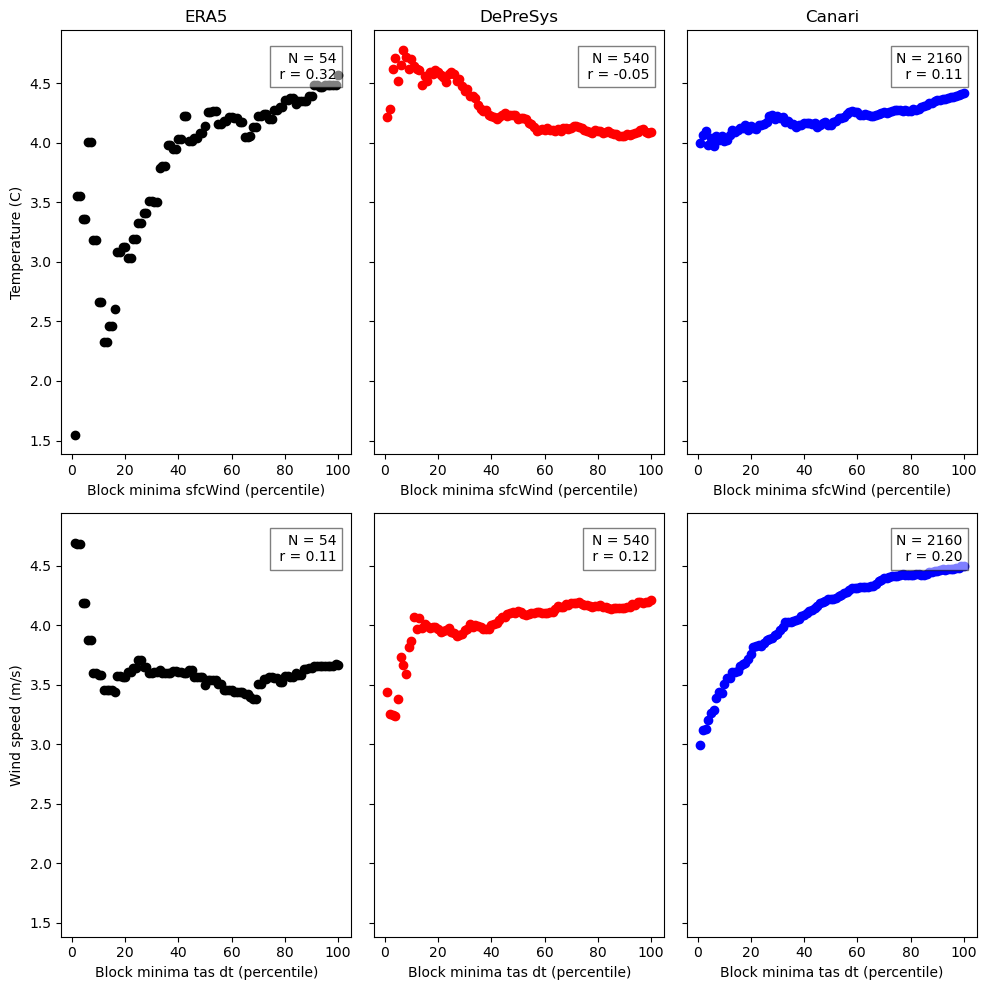

In [56]:
from scipy.stats import pearsonr

# Set up two subplots
# one row, two columns
fig, axs = plt.subplots(2, 3, figsize=(10, 10), sharey=True)

# Plot a scatter of the worst wind days
# with the tas values on these worst wind days
axs[0, 0].scatter(
    obs_df_percentiles["percentile"],
    obs_df_percentiles["mean_tas_dt_worst_wind"],
    color="black",
    label="ERA5 DJF block minima",
)

# calculate the correlation between full_obs_df["data_wind"] and full_obs_df["data_tas_dt"]
corr_obs_worst_wind_tas_dt, _ = pearsonr(full_obs_df["data_wind"], full_obs_df["data_tas_worst_wind_dt"])

# Set up the xlable
axs[0, 0].set_xlabel("Block minima sfcWind (percentile)")

# Set up the ylabel
axs[0, 0].set_ylabel("Temperature (C)")

# Set up the title
axs[0, 0].set_title("ERA5")

# # mark the max value of wind speed with a solid green vertical line
# axs[0].axvline(df_obs_worst_djf_days["data_wind"].max(), color="green", linestyle="-", label="ERA5 max")

# # mark the max value of temperature with a solid red horizontal line
# axs[0].axhline(df_obs_worst_djf_days["data_tas_dt"].max(), color="red", linestyle="-", label="ERA5 max")

# Plot a scatter
# of the worst temperature days
# with the wind values on these worst temperature days
axs[1, 0].scatter(
    obs_df_percentiles["percentile"],
    obs_df_percentiles["mean_wind_worst_tas_dt"],
    color="black",
    label="ERA5 DJF block minima",
)

# calculate the correlation between full_obs_df["data_tas_dt"] and full_obs_df["data_wind_worst_tas"]
corr_obs_worst_tas_dt_wind, _ = pearsonr(full_obs_df["data_tas_dt"], full_obs_df["data_wind_worst_tas"])

# Set up the xlable
axs[1, 0].set_xlabel("Block minima tas dt (percentile)")

# # Set up the xlable
# axs[1, 1].set_xlabel("Percentile of block minima Temperature (detrended)")

# set up the ylabel
axs[1, 0].set_ylabel("Wind speed (m/s)")

# # Set up the title
# axs[1, 0].set_title("ERA5")

# # set up a dashed blue line at 0
# axs[1, 0].axhline(0, color="blue", linestyle="--")

# # Calculate the 0th and 50th percentiles for wind speed
# wind_0th_percentile = df_obs_worst_djf_days["data_wind"].quantile(0.00)
# wind_50th_percentile = df_obs_worst_djf_days["data_wind"].quantile(0.50)

# # Calculate the 0th and 50th percentiles for temperature
# temp_0th_percentile = df_obs_worst_djf_days["data_tas_dt"].quantile(0.00)
# temp_50th_percentile = df_obs_worst_djf_days["data_tas_dt"].quantile(0.50)

# # Mark the 0th and 50th percentiles of wind speed with solid green vertical lines
# axs[1, 0].axvline(wind_0th_percentile, color="green", linestyle="-", label="ERA5 0th percentile")
# axs[1, 0].axvline(wind_50th_percentile, color="green", linestyle="-", label="ERA5 50th percentile")

# # Mark the 0th and 50th percentiles of temperature with solid red horizontal lines
# axs[1, 0].axhline(temp_0th_percentile, color="red", linestyle="-", label="ERA5 0th percentile")
# axs[1, 0].axhline(temp_50th_percentile, color="red", linestyle="-", label="ERA5 50th percentile")

# axs[0, 0].axvline(wind_0th_percentile, color="green", linestyle="-", label="ERA5 0th percentile")
# axs[0, 0].axvline(wind_50th_percentile, color="green", linestyle="-", label="ERA5 50th percentile")

# axs[0, 0].axhline(temp_0th_percentile, color="red", linestyle="-", label="ERA5 0th percentile")
# axs[0, 0].axhline(temp_50th_percentile, color="red", linestyle="-", label="ERA5 50th percentile")

# quantify the n points in the low wind, cold temp regions
#i.e. within both the 0th and 50th percentiles of wind speed and temperature
# n_points_worst_wind_cold_temp_obs = df_obs_worst_djf_days[
#     (df_obs_worst_djf_days["data_wind"] <= wind_50th_percentile)
#     & (df_obs_worst_djf_days["data_wind"] >= wind_0th_percentile)
#     & (df_obs_worst_djf_days["data_tas_worst_wind_dt"] <= temp_50th_percentile)
#     & (df_obs_worst_djf_days["data_tas_worst_wind_dt"] >= temp_0th_percentile)
# ].shape[0]

# n_points_worst_temp_low_wind_obs = df_obs_worst_djf_days[
#     (df_obs_worst_djf_days["data_wind_worst_tas"] <= wind_50th_percentile)
#     & (df_obs_worst_djf_days["data_wind_worst_tas"] >= wind_0th_percentile)
#     & (df_obs_worst_djf_days["data_tas_dt"] <= temp_50th_percentile)
#     & (df_obs_worst_djf_days["data_tas_dt"] >= temp_0th_percentile)
# ].shape[0]

# cinlude the total N points
axs[0, 0].text(
    0.95,
    0.95,
    f"N = {len(full_obs_df)}\n r = {corr_obs_worst_wind_tas_dt:.2f}",
    transform=axs[0, 0].transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
    horizontalalignment="right",
    verticalalignment="top",
)

# include the total N points
axs[1, 0].text(
    0.95,
    0.95,
    f"N = {len(full_obs_df)}\n r = {corr_obs_worst_tas_dt_wind:.2f}",
    transform=axs[1, 0].transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
    horizontalalignment="right",
    verticalalignment="top",
)

# # Shade the region where the 0th to 50th percentiles of wind speed and temperature intersect
# axs[0, 0].fill_betweenx(
#     [temp_0th_percentile, temp_50th_percentile],
#     wind_0th_percentile,
#     wind_50th_percentile,
#     color="gray",
#     alpha=0.3,
#     label="0th-50th percentile region"
# )

# # Shade the region where the 0th to 50th percentiles of wind speed and temperature intersect
# axs[1, 0].fill_betweenx(
#     [temp_0th_percentile, temp_50th_percentile],
#     wind_0th_percentile,
#     wind_50th_percentile,
#     color="gray",
#     alpha=0.3,
#     label="0th-50th percentile region"
# )

# # Add legend
# axs[0].legend()
# axs[1].legend()

# # include text on the lower red line in red, saying "cold temps"
# axs[1, 0].text(
#     8,
#     -4.8,
#     "cold temps",
#     color="red",
#     horizontalalignment="right",
# )

# # include vertical text on the left most green in green, saying "low wind"
# axs[1, 0].text(
#     1.8,
#     6,
#     "low wind",
#     color="green",
#     verticalalignment="top",
#     horizontalalignment="right",
#     rotation=270,
# )

# # set the xlims (1 -10)
# axs[1, 0].set_xlim(1, 9)

# # set the xlabel
# axs[1, 0].set_xlabel("Wind speed (m/s)")

# # set the ylabel
# axs[1, 0].set_ylabel("Temperature (C)")

# set up the third subplot
# Plot a scatter of the worst wind days
# for the model data
axs[0, 1].scatter(
    dps_df_percentiles["percentile"],
    dps_df_percentiles["mean_tas_dt_worst_wind"],
    color="red",
    label="DePreSys DJF block minima",
)

# calculate teh correlation
corr_dps_worst_wind_tas_dt, _ = pearsonr(dps_df["data_wind"], dps_df["data_tas_worst_wind_dt"])

# Set up the xlable
# axs[1, 0].set_xlabel("Wind speed (m/s)")
axs[0, 1].set_xlabel("Block minima sfcWind (percentile)")

# # set up the ylabel
# axs[0, 1].set_ylabel("Temperature (C)")

# set up the title
axs[0, 1].set_title("DePreSys")

# set up a dashed blue line at 0
# axs[1, 0].axhline(0, color="blue", linestyle="--")

# # set the xlims (1 -10)
# axs[0, 1].set_xlim(1, 9)

# Plot a scatter
# of the worst temperature days
# for the model data
axs[1, 1].scatter(
    dps_df_percentiles["percentile"],
    dps_df_percentiles["mean_wind_worst_tas"],
    color="red",
    label="DePreSys DJF block minima",
)

# Calculate the correlation
corr_dps_worst_tas_dt_wind, _ = pearsonr(dps_df["data_tas_dt"], dps_df["data_wind_worst_tas"])

# Set up the xlable
axs[1, 1].set_xlabel("Block minima tas dt (percentile)")

# Set up the title
# axs[1, 1].set_title("DePreSys")

# set up a dashed blue line at 0
# axs[1, 1].axhline(0, color="blue", linestyle="--")

# Calculate the 0th and 50th percentiles for wind speed
# wind_0th_percentile = df_model_worst_djf_days["data_wind"].quantile(0.00)
# wind_50th_percentile = df_model_worst_djf_days["data_wind"].quantile(0.50)

# # Calculate the 0th and 50th percentiles for temperature
# temp_0th_percentile = df_model_worst_djf_days["data_tas_dt"].quantile(0.00)
# temp_50th_percentile = df_model_worst_djf_days["data_tas_dt"].quantile(0.50)

# # Mark the 0th and 50th percentiles of wind speed with solid green vertical lines
# axs[1, 1].axvline(wind_0th_percentile, color="green", linestyle="-", label="DePreSys 0th percentile")
# axs[1, 1].axvline(wind_50th_percentile, color="green", linestyle="-", label="DePreSys 50th percentile")

# # Mark the 0th and 50th percentiles of temperature with solid red horizontal lines
# axs[1, 1].axhline(temp_0th_percentile, color="red", linestyle="-", label="DePreSys 0th percentile")
# axs[1, 1].axhline(temp_50th_percentile, color="red", linestyle="-", label="DePreSys 50th percentile")

# axs[0, 1].axvline(wind_0th_percentile, color="green", linestyle="-", label="DePreSys 0th percentile")
# axs[0, 1].axvline(wind_50th_percentile, color="green", linestyle="-", label="DePreSys 50th percentile")

# axs[0, 1].axhline(temp_0th_percentile, color="red", linestyle="-", label="DePreSys 0th percentile")
# axs[0, 1].axhline(temp_50th_percentile, color="red", linestyle="-", label="DePreSys 50th percentile")

# # include the total N points
# n_points_worst_wind_cold_temp_dps = df_model_worst_djf_days[
#     (df_model_worst_djf_days["data_wind"] <= wind_50th_percentile)
#     & (df_model_worst_djf_days["data_wind"] >= wind_0th_percentile)
#     & (df_model_worst_djf_days["data_tas_worst_wind_dt"] <= temp_50th_percentile)
#     & (df_model_worst_djf_days["data_tas_worst_wind_dt"] >= temp_0th_percentile)
# ].shape[0]

# n_points_worst_temp_low_wind_dps = df_model_worst_djf_days[
#     (df_model_worst_djf_days["data_wind_worst_tas"] <= wind_50th_percentile)
#     & (df_model_worst_djf_days["data_wind_worst_tas"] >= wind_0th_percentile)
#     & (df_model_worst_djf_days["data_tas_dt"] <= temp_50th_percentile)
#     & (df_model_worst_djf_days["data_tas_dt"] >= temp_0th_percentile)
# ].shape[0]

# cinlude the total N points
axs[0, 1].text(
    0.95,
    0.95,
    f"N = {len(dps_df)}\n r = {corr_dps_worst_wind_tas_dt:.2f}",
    transform=axs[0, 1].transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
    horizontalalignment="right",
    verticalalignment="top",
)

# include the total N points
axs[1, 1].text(
    0.95,
    0.95,
    f"N = {len(dps_df)}\n r = {corr_dps_worst_tas_dt_wind:.2f}",
    transform=axs[1, 1].transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
    horizontalalignment="right",
    verticalalignment="top",
)

# Shade the region where the 0th to 50th percentiles of wind speed and temperature intersect
# axs[0, 1].fill_betweenx(
#     [temp_0th_percentile, temp_50th_percentile],
#     wind_0th_percentile,
#     wind_50th_percentile,
#     color="gray",
#     alpha=0.3,
#     label="0th-50th percentile region"
# )

# # Shade the region where the 0th to 50th percentiles of wind speed and temperature intersect
# axs[1, 1].fill_betweenx(
#     [temp_0th_percentile, temp_50th_percentile],
#     wind_0th_percentile,
#     wind_50th_percentile,
#     color="gray",
#     alpha=0.3,
#     label="0th-50th percentile region"
# )

# in position 0, 2
#plot the canari data
axs[0, 2].scatter(
    canari_df_percentiles["percentile"],
    canari_df_percentiles["mean_tas_dt_worst_wind"],
    color="blue",
    label="Canari DJF block minima",
)

# Calculate the correlations
corr_canari_worst_wind_tas_dt, _ = pearsonr(canari_df["data_wind"], canari_df["data_tas_worst_wind_dt"])

# Set up the title
axs[0, 2].set_title("Canari")

# Set up the xlable
axs[0, 2].set_xlabel("Block minima sfcWind (percentile)")

# # set up the horizontal lines for the 0th and 50th percentiles
# axs[0, 2].axhline(temp_0th_percentile, color="red", linestyle="-", label="Canari 0th percentile")
# axs[0, 2].axhline(temp_50th_percentile, color="red", linestyle="-", label="Canari 50th percentile")

# # set up the vertical lines for the 0th and 50th percentiles
# axs[0, 2].axvline(wind_0th_percentile, color="green", linestyle="-", label="Canari 0th percentile")
# axs[0, 2].axvline(wind_50th_percentile, color="green", linestyle="-", label="Canari 50th percentile")

# # highlight the region where the 0th to 50th percentiles intersect
# axs[0, 2].fill_betweenx(
#     [temp_0th_percentile, temp_50th_percentile],
#     wind_0th_percentile,
#     wind_50th_percentile,
#     color="gray",
#     alpha=0.3,
#     label="0th-50th percentile region"
# )

# # Plot a scatter
# # of the worst temperature days
# # for the model data
axs[1, 2].scatter(
    canari_df_percentiles["percentile"],
    canari_df_percentiles["mean_wind_worst_tas"],
    color="blue",
    label="Canari DJF block minima",
)

# calculate the correlations
corr_canari_worst_tas_dt_wind, _ = pearsonr(canari_df["data_tas_dt"], canari_df["data_wind_worst_tas"])

# Set up the xlable
axs[1, 2].set_xlabel("Block minima tas dt (percentile)")

# Set up the title
# axs[1, 1].set_title("Canari")

# set up a dashed blue line at 0
# axs[1, 1].axhline(0, color="blue", linestyle="--")

# Calculate the 0th and 50th percentiles for wind speed
# wind_0th_percentile = df_canari_worst_djf_days["data_wind"].quantile(0.00)

# highlight the regions
# axs[1, 2].axvline(wind_0th_percentile, color="green", linestyle="-", label="Canari 0th percentile")
# axs[1, 2].axvline(wind_50th_percentile, color="green", linestyle="-", label="Canari 50th percentile")

# # highlight the regions
# axs[1, 2].axhline(temp_0th_percentile, color="red", linestyle="-", label="Canari 0th percentile")
# axs[1, 2].axhline(temp_50th_percentile, color="red", linestyle="-", label="Canari 50th percentile")

# highlight the region
# axs[1, 2].fill_betweenx(
#     [temp_0th_percentile, temp_50th_percentile],
#     wind_0th_percentile,
#     wind_50th_percentile,
#     color="gray",
#     alpha=0.3,
#     label="0th-50th percentile region"
# )

# # include the total N points
# n_points_worst_wind_cold_temp_canari = df_canari_worst_djf_days[
#     (df_canari_worst_djf_days["data_wind"] <= wind_50th_percentile)
#     & (df_canari_worst_djf_days["data_wind"] >= wind_0th_percentile)
#     & (df_canari_worst_djf_days["data_tas_worst_wind_dt"] <= temp_50th_percentile)
#     & (df_canari_worst_djf_days["data_tas_worst_wind_dt"] >= temp_0th_percentile)
# ].shape[0]

# n_points_worst_temp_low_wind_canari = df_canari_worst_djf_days[
#     (df_canari_worst_djf_days["data_wind_worst_tas"] <= wind_50th_percentile)
#     & (df_canari_worst_djf_days["data_wind_worst_tas"] >= wind_0th_percentile)
#     & (df_canari_worst_djf_days["data_tas_dt"] <= temp_50th_percentile)
#     & (df_canari_worst_djf_days["data_tas_dt"] >= temp_0th_percentile)
# ].shape[0]

# cinlude the total N points
axs[0, 2].text(
    0.95,
    0.95,
    f"N = {len(canari_df)}\n r = {corr_canari_worst_wind_tas_dt:.2f}",
    transform=axs[0, 2].transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
    horizontalalignment="right",
    verticalalignment="top",
)

# include the total N points
axs[1, 2].text(
    0.95,
    0.95,
    f"N = {len(canari_df)}\n r = {corr_canari_worst_tas_dt_wind:.2f}",
    transform=axs[1, 2].transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
    horizontalalignment="right",
    verticalalignment="top",
)

# set a tight layout
plt.tight_layout()